In [588]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [589]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the Alpaca api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [590]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [591]:
list_of_tickers = ["SPY", "AGG"]

# Set timeframe to '1D' i.e. everyday
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
# end_date = datetime.now()
# start_date = end_date + timedelta(-365)

# Alpeca has an issue with getting less than 5 mo. data
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for TSLA
df = api.get_barset(
    list_of_tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()



AGG                                          \
                             open     high       low    close      volume   
2019-01-02 00:00:00-05:00  106.55  106.610  106.4701  106.585  10164756.0   
2019-01-03 00:00:00-05:00  106.57  107.075  106.5700  107.020   6260265.0   
2019-01-04 00:00:00-05:00  106.66  106.720  106.5500  106.695   7755476.0   
2019-01-07 00:00:00-05:00  106.72  106.790  106.4600  106.470   6545877.0   
2019-01-08 00:00:00-05:00  106.40  106.530  105.5300  106.420   3818241.0   

                              SPY                                     
                             open    high     low   close     volume  
2019-01-02 00:00:00-05:00  245.98  251.21  245.95  249.89  107236613  
2019-01-03 00:00:00-05:00  248.23  248.57  244.03  244.46  113782919  
2019-01-04 00:00:00-05:00  247.59  253.11  247.17  252.41  122528832  
2019-01-07 00:00:00-05:00  252.69  255.95  251.69  254.40   88317608  
2019-01-08 00:00:00-05:00  256.82  257.31  254.00  256.65   88864452

In [592]:
# Clean up Data

# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date
df.sort_index(inplace=True)
df.columns = ["AGG","SPY"]
df.tail()


,AGG,SPY
2019-12-24,112.375,321.26
2019-12-26,112.480,322.91
2019-12-27,112.620,322.86
2019-12-30,112.630,321.10
2019-12-31,112.370,321.92


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [593]:
# Calculate the daily roi for the stocks

daily_returns = df.pct_change()
daily_returns.dropna(inplace = True)

avg_daily_return_spy = daily_returns.mean()['AGG']
avg_daily_return_agg = daily_returns.mean()['SPY']

daily_returns.head()

,AGG,SPY
2019-01-03,0.004081,-0.021730
2019-01-04,-0.003037,0.032521
2019-01-07,-0.002109,0.007884
2019-01-08,-0.000470,0.008844
2019-01-09,0.000564,0.004130


In [594]:
# Calculate volatility

std_dev_daily_return_spy = daily_returns['SPY'].std()
std_dev_daily_return_agg = daily_returns['AGG'].std()


In [595]:
# Save the last day's closing price

spy_last_closing = df['SPY'][-1]
agg_last_closing = df['AGG'][-1]


In [597]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
monte_carlo = pd.DataFrame()

In [598]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `SPY` and `AGG`
    simulated_spy_prices = [spy_last_closing]
    simulated_agg_prices = [agg_last_closing]
    
    # Simulate the returns for 252 * 30 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        
        # Append the simulated price to the list
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()

    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    monte_carlo[f'Simulation {x}'] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
monte_carlo.head()
    

,Simulation 0,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,...,Simulation 490,Simulation 491,Simulation 492,Simulation 493,Simulation 494,Simulation 495,Simulation 496,Simulation 497,Simulation 498,Simulation 499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002759,0.995833,0.993424,0.999673,1.005507,1.006778,1.009236,0.996391,1.001793,0.999185,...,1.002103,0.995805,1.007142,0.999997,0.997733,1.003042,0.996276,0.993979,1.003043,0.997388
2,1.007627,0.999667,0.992738,0.998709,1.008738,0.997863,1.003792,0.985970,1.001015,1.007498,...,1.004186,1.003039,1.010213,1.001638,0.999145,0.999944,0.995806,0.994446,1.002980,1.001113
3,1.006871,0.999735,0.996228,0.993026,1.008117,1.000912,1.007638,0.980093,1.000824,1.015600,...,1.004245,1.005743,1.014842,1.003130,0.992679,0.998745,0.999503,0.999998,1.006329,0.999985
4,1.015525,1.002619,0.992738,0.998779,1.009627,0.996017,1.006453,0.977394,1.008632,1.005642,...,1.006137,1.004014,1.013462,1.008244,0.998782,0.995816,0.993985,1.000724,1.010836,1.003467


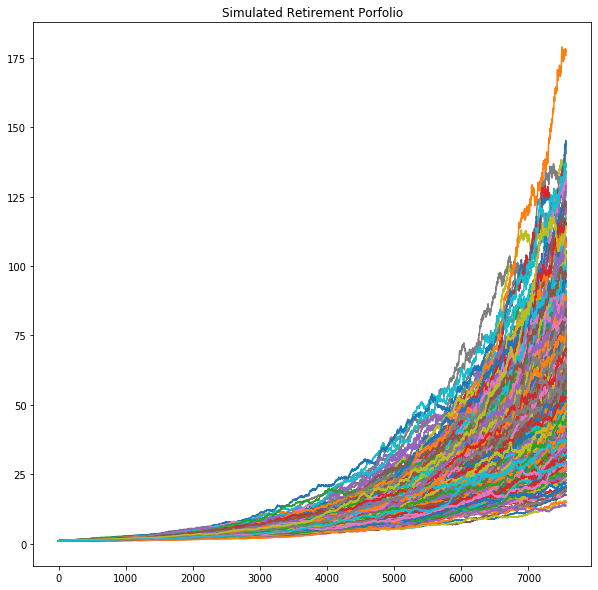

In [599]:
# Visualize the Simulation
# Use the `plot` function to plot `500` simulations of the potential trajectories of the portfolio based on 252x30 trading days
plot_title = "Simulated Retirement Porfolio"
monte_carlo.plot(legend=None, title=plot_title, figsize=(10,10))


In [600]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns_30 = monte_carlo.iloc[-1, :]
ending_cumulative_returns_30.tail()


Simulation 495     96.605035
Simulation 496     28.155789
Simulation 497     61.457458
Simulation 498    113.690966
Simulation 499     28.961934
Name: 7560, dtype: float64

In [601]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns_20 = monte_carlo.iloc[252*20, :]
ending_cumulative_returns_20.tail()


Simulation 495    21.156103
Simulation 496     8.634642
Simulation 497    16.659853
Simulation 498    21.020026
Simulation 499    11.833706
Name: 5040, dtype: float64

In [602]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns_30.quantile(q=[0.05, 0.95])
confidence_interval


0.05     27.023931
0.95    107.339459
Name: 7560, dtype: float64

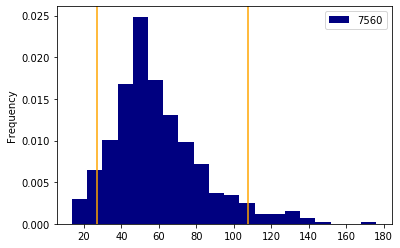

In [603]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns_30.plot(kind='hist', density=True, bins=20, colormap='jet', legend=True)
plt.axvline(confidence_interval.iloc[0], color='orange')
plt.axvline(confidence_interval.iloc[1], color='orange')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [578]:
cumu_returns_quantile_10 = ending_cumulative_returns_30.quantile(q=[.1]).round(3).values[0]

print(f'Cumulative Returns at 30 years for the 10th percentile is {cumu_returns_quantile_10}')

# cumu_returns_quantile_50 = ending_cumulative_returns_30.quantile(q=[.5])
# print(f'Cumulative Returns at 30 years for the 50th percentile {cumu_returns_quantile_50}')
median = round(ending_cumulative_returns_30.median(),3)
print(f'Cumulative Returns at 30 years for the 50th percentile is {median}')
cumu_returns_quantile_90 = ending_cumulative_returns_30.quantile(q=[.9]).round(3).values[0]
print(f'Cumulative Returns at 30 years for the 90th percentile is {cumu_returns_quantile_90}')


Cumulative Returns at 30 years for the 10th percentile is 33.621
Cumulative Returns at 30 years for the 50th percentile is 54.379
Cumulative Returns at 30 years for the 90th percentile is 90.047


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [579]:
# Set initial investment
initial_investment = 20000


# Calculate investment profit/loss of 10,50,90 percentile cumulative portfolio returns
investment_pnl_10_quantile = initial_investment * cumu_returns_quantile_10

investment_pnl_50_quantile = initial_investment * median

investment_pnl_90_quantile = initial_investment * cumu_returns_quantile_90


# Print the results
print(f"Expected porfolio return with initial investment of $20,000 over 30 years \n at the 10th percentile NOT including the intial investment is"
      f" ${investment_pnl_10_quantile}")

print(f"Expected porfolio return with initial investment of $20,000 over 30 years \n at the 50th percentile NOT including the intial investment is"
      f" ${investment_pnl_50_quantile}")

print(f"print(Expected porfolio return with initial investment of $20,000 over 30 years \n at the 90th percentile NOT including the intial investment is"

      f" ${investment_pnl_90_quantile}")


Expected porfolio return with initial investment of $20,000 over 30 years 
 at the 10th percentile NOT including the intial investment is $672420.0
Expected porfolio return with initial investment of $20,000 over 30 years 
 at the 50th percentile NOT including the intial investment is $1087580.0
print(Expected porfolio return with initial investment of $20,000 over 30 years 
 at the 90th percentile NOT including the intial investment is $1800940.0


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [580]:
four_percent_rule = round(investment_pnl_10_quantile * 0.04, 3)
print(f'${four_percent_rule} is greater than the projected income of $7389 .\nSo the retirement porfolio exceeds the value at 10th percentile')


$26896.8 is greater than the projected income of $7389 .
So the retirement porfolio exceeds the value at 10th percentile


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [581]:
initial_investment_50percent_incr = 20000 * 1.5
print(f'Intial investemnt increased to: {initial_investment_50percent_incr}')

# Calculate investment profit/loss of 10,50,90 percentile cumulative portfolio returns
investment_pnl_10_quantile_new = initial_investment_50percent_incr * cumu_returns_quantile_10

four_percent_rule_new = round((investment_pnl_10_quantile_new * 0.04), 3)
print(f'${four_percent_rule_new} is greater than the projected income of $7389 .\nSo the retirement porfolio exceeds the value at 10th percentile')


Intial investemnt increased to: 30000.0
$40345.2 is greater than the projected income of $7389 .
So the retirement porfolio exceeds the value at 10th percentile


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

,0,1,2,3,4,5,6,7,8,9,...,7551,7552,7553,7554,7555,7556,7557,7558,7559,7560
0.05,1.0,0.992806,0.990810,0.988806,0.986655,0.985754,0.984615,0.984288,0.983212,0.981867,...,27.000831,26.919512,27.033217,27.120498,26.982103,27.030341,27.190576,27.221451,27.136564,27.023931
0.50,1.0,1.000643,1.001444,1.001880,1.002662,1.003304,1.003144,1.003815,1.004985,1.005677,...,54.134202,54.202926,54.085711,54.244620,54.317425,54.349463,54.397981,54.366586,54.372556,54.379474
0.95,1.0,1.008612,1.012090,1.015603,1.017030,1.020251,1.022520,1.023908,1.026401,1.028866,...,107.695999,107.168583,107.400232,107.624865,107.644842,107.013475,107.221891,107.533430,107.611878,107.339459


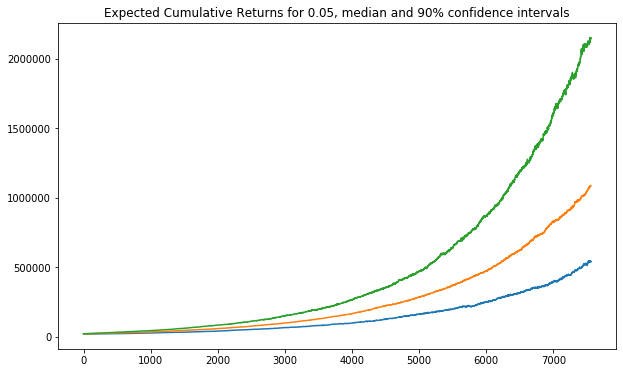

In [708]:
interval = monte_carlo.quantile(q=[0.05,0.5,0.95], axis=1)
initial_investment_df = pd.DataFrame(interval*20000)

ax_5per=(initial_investment_df.iloc[0,:]).plot(title="Expected Cumulative Returns for 0.05, median and 90% confidence intervals", figsize=(10,6))
median =(initial_investment_df.iloc[1,:]).plot(ax=ax_5per)
ax_90per =(initial_investment_df.iloc[2,:]).plot(ax=ax_5per)

ax.legend(['0.05','0.5','.90'])
interval.head()